In [1]:
from google.cloud import bigquery
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree


In [2]:
#Importando Dados do Big Query

In [3]:
client = bigquery.Client()

sql_query = """
select
     eng.cliente
    ,eng.user_id
    ,eng.environment_id
    ,eng.course_id
    ,eng.space_id
    ,eng.subject_id
    ,eng.lecture_id
    ,eng.NivelAgregacao
    ,eng.user_name
    ,eng.environment_name
    ,eng.course_name
    ,eng.space_name
    ,eng.subject_name
    ,eng.lecture_name
    ,eng.postsAmount
    ,eng.postRepliesAmount
    ,eng.helpRequestsAmount
    ,eng.helpRequestRepliesAmount
    ,eng.performance_rate
from analytics.fn_engajamento(
  DATE('2020-01-01'),
  DATE('2024-12-31'),
  TRUE,'redu-digital',
  242,
  NULL,
  NULL,
  NULL,
  NULL,'ENV'
) as eng
inner join (
	select 
		uea.user_id
		,uea.cliente 
	from replicas.user_environment_associations uea 
	where uea.role not in ('teacher', 'tutor', 'environment_admin')
) as filtro on filtro.cliente = eng.cliente and filtro.user_id = eng.user_id

"""
dataframe = client.query(sql_query).to_dataframe()

In [4]:
## EDA dos dados importados 

In [5]:
print(dataframe.head())
dataframe.info()

        cliente  user_id  environment_id  course_id  space_id  subject_id  \
0  redu-digital      275             242       <NA>      <NA>        <NA>   
1  redu-digital     7991             242       <NA>      <NA>        <NA>   
2  redu-digital     7992             242       <NA>      <NA>        <NA>   
3  redu-digital     7993             242       <NA>      <NA>        <NA>   
4  redu-digital     8000             242       <NA>      <NA>        <NA>   

   lecture_id NivelAgregacao                                      user_name  \
0        <NA>            ENV                                Leandro Marques   
1        <NA>            ENV                    Jose Allyson Cosmo de Brito   
2        <NA>            ENV  Diego Henrique Nascimento Caetano de Oliveira   
3        <NA>            ENV        Joseilma Pereira de Carvalho Cavalcanti   
4        <NA>            ENV                               DANIELA DA SILVA   

        environment_name course_name space_name subject_name l

In [6]:
dataframe.describe()

,user_id,environment_id,course_id,space_id,subject_id,lecture_id,postsAmount,postRepliesAmount,helpRequestsAmount,helpRequestRepliesAmount,performance_rate
count,2885.0,2885.0,0.0,0.0,0.0,0.0,2885.0,2885.0,2885.0,2885.0,1244.000000
mean,10990.002773,242.0,<NA>,<NA>,<NA>,<NA>,1.482149,0.024957,0.011438,0.00208,0.406853
std,1952.723316,0.0,<NA>,<NA>,<NA>,<NA>,10.599347,0.395976,0.132487,0.045564,0.461396
min,9.0,242.0,<NA>,<NA>,<NA>,<NA>,0.0,0.0,0.0,0.0,0.000000
25%,9176.0,242.0,<NA>,<NA>,<NA>,<NA>,0.0,0.0,0.0,0.0,0.000000
50%,11167.0,242.0,<NA>,<NA>,<NA>,<NA>,0.0,0.0,0.0,0.0,0.000000
75%,12745.0,242.0,<NA>,<NA>,<NA>,<NA>,0.0,0.0,0.0,0.0,1.000000
max,16250.0,242.0,<NA>,<NA>,<NA>,<NA>,281.0,13.0,3.0,1.0,1.000000


In [7]:
valores_set = dataframe.iloc[:, 14:]

In [8]:
valores_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2885 entries, 0 to 2884
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   postsAmount               2885 non-null   Int64  
 1   postRepliesAmount         2885 non-null   Int64  
 2   helpRequestsAmount        2885 non-null   Int64  
 3   helpRequestRepliesAmount  2885 non-null   Int64  
 4   performance_rate          1244 non-null   float64
dtypes: Int64(4), float64(1)
memory usage: 124.1 KB


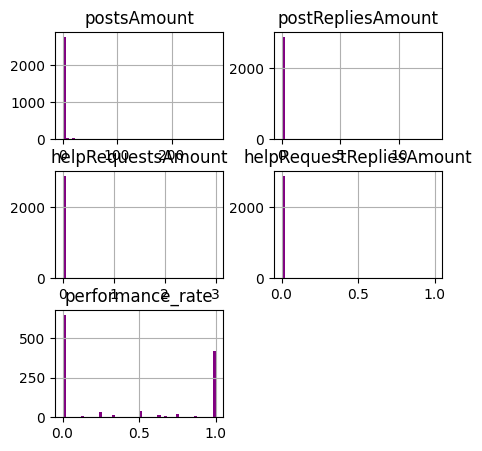

In [9]:
valores_set.hist(bins=50, figsize=(5, 5), color='purple')
plt.show()

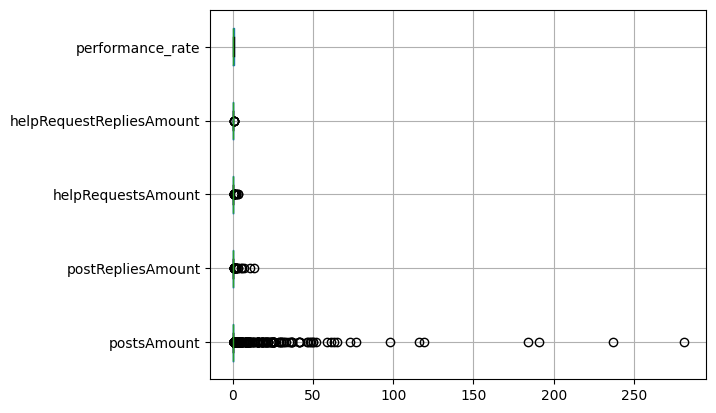

In [10]:
valores_set.boxplot(vert=False)
plt.show()

In [11]:
## pré processamento

In [12]:
train_set = valores_set.copy()

In [13]:
train_set.shape

(2885, 5)

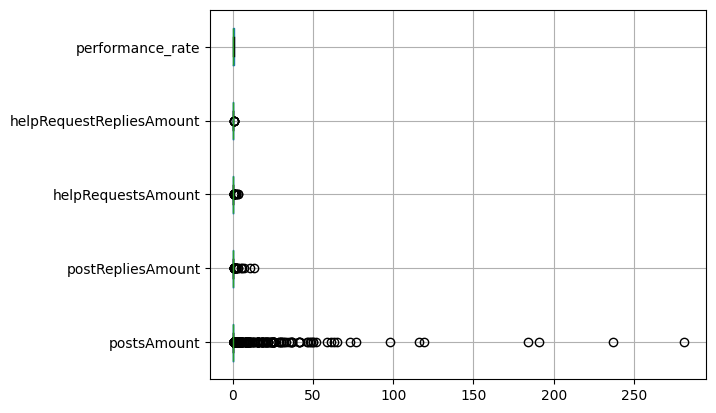

In [14]:
train_set.boxplot(vert=False)
plt.show()

In [15]:
train_set.info()
train_set.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2885 entries, 0 to 2884
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   postsAmount               2885 non-null   Int64  
 1   postRepliesAmount         2885 non-null   Int64  
 2   helpRequestsAmount        2885 non-null   Int64  
 3   helpRequestRepliesAmount  2885 non-null   Int64  
 4   performance_rate          1244 non-null   float64
dtypes: Int64(4), float64(1)
memory usage: 124.1 KB


,postsAmount,postRepliesAmount,helpRequestsAmount,helpRequestRepliesAmount,performance_rate
count,2885.0,2885.0,2885.0,2885.0,1244.000000
mean,1.482149,0.024957,0.011438,0.00208,0.406853
std,10.599347,0.395976,0.132487,0.045564,0.461396
min,0.0,0.0,0.0,0.0,0.000000
25%,0.0,0.0,0.0,0.0,0.000000
50%,0.0,0.0,0.0,0.0,0.000000
75%,0.0,0.0,0.0,0.0,1.000000
max,281.0,13.0,3.0,1.0,1.000000


In [16]:
train_set.head()

,postsAmount,postRepliesAmount,helpRequestsAmount,helpRequestRepliesAmount,performance_rate
0,0,0,0,0,0.0
1,10,0,0,0,NaN
2,0,0,0,1,NaN
3,0,0,0,0,NaN
4,0,0,0,0,0.0


In [17]:
inputer = KNNImputer(n_neighbors=5)
inputer.fit(train_set)

,missing_values,nan
,n_neighbors,5
,weights,'uniform'
,metric,'nan_euclidean'
,copy,True
,add_indicator,False
,keep_empty_features,False


In [18]:
train_set_inpute = inputer.transform(train_set)

In [19]:
train_set_inputado = pd.DataFrame(
    train_set_inpute,
    columns=train_set.columns,
    index=train_set.index
)

In [20]:
train_set = train_set_inputado.copy()
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2885 entries, 0 to 2884
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   postsAmount               2885 non-null   float64
 1   postRepliesAmount         2885 non-null   float64
 2   helpRequestsAmount        2885 non-null   float64
 3   helpRequestRepliesAmount  2885 non-null   float64
 4   performance_rate          2885 non-null   float64
dtypes: float64(5)
memory usage: 112.8 KB


In [21]:
train_set.describe()

,postsAmount,postRepliesAmount,helpRequestsAmount,helpRequestRepliesAmount,performance_rate
count,2885.000000,2885.000000,2885.000000,2885.000000,2885.000000
mean,1.482149,0.024957,0.011438,0.002080,0.314410
std,10.599347,0.395976,0.132487,0.045564,0.330438
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.200000
50%,0.000000,0.000000,0.000000,0.000000,0.200000
75%,0.000000,0.000000,0.000000,0.000000,0.333333
max,281.000000,13.000000,3.000000,1.000000,1.000000


In [22]:
print(train_set.columns)

Index(['postsAmount', 'postRepliesAmount', 'helpRequestsAmount',
       'helpRequestRepliesAmount', 'performance_rate'],
      dtype='object')


In [23]:
#performance_rate = train_set['performance_rate']

#train_Set = train_set.drop('performance_rate', axis=1)

In [24]:
scaler = MinMaxScaler()
#feature_range=(-1, 1)
train_set_scaled_np = scaler.fit_transform(train_set)

In [25]:
train_set_scaled = pd.DataFrame(
train_set_scaled_np,
    columns=train_set.columns,
    index=train_set.index
)

In [26]:
#train_set['performance_rate'] = performance_rate

In [27]:
train_set = train_set_scaled.copy()

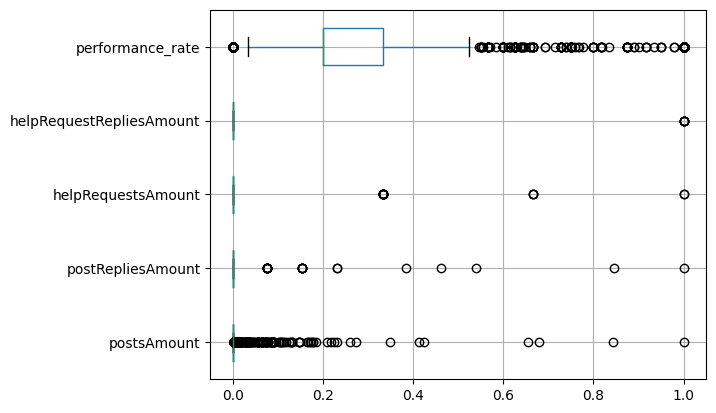

In [28]:
train_set.boxplot(vert=False)
plt.show()

In [29]:
#test_cols = test_set.columns
#test_idx = test_set.index

#test_set = pd.DataFrame(imputer.transform(test_set), columns=test_cols, index=test_idx)
#test_set = pd.DataFrame(scaler.transform(test_set), columns=test_cols, index=test_idx)

In [30]:
# faixas de k para testar
k_range = range(2, 11)  # começa em 2 (não faz sentido silhouette com k=1)

# métricas
wcss = []
silhouette = []
calinski = []
davies = []
bic = []

for k in k_range:
    # KMeans
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(train_set)

    wcss.append(kmeans.inertia_)
    silhouette.append(silhouette_score(train_set, labels))
    calinski.append(calinski_harabasz_score(train_set, labels))
    davies.append(davies_bouldin_score(train_set, labels))

    # BIC com GaussianMixture
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm.fit(train_set)
    bic.append(gmm.bic(train_set))

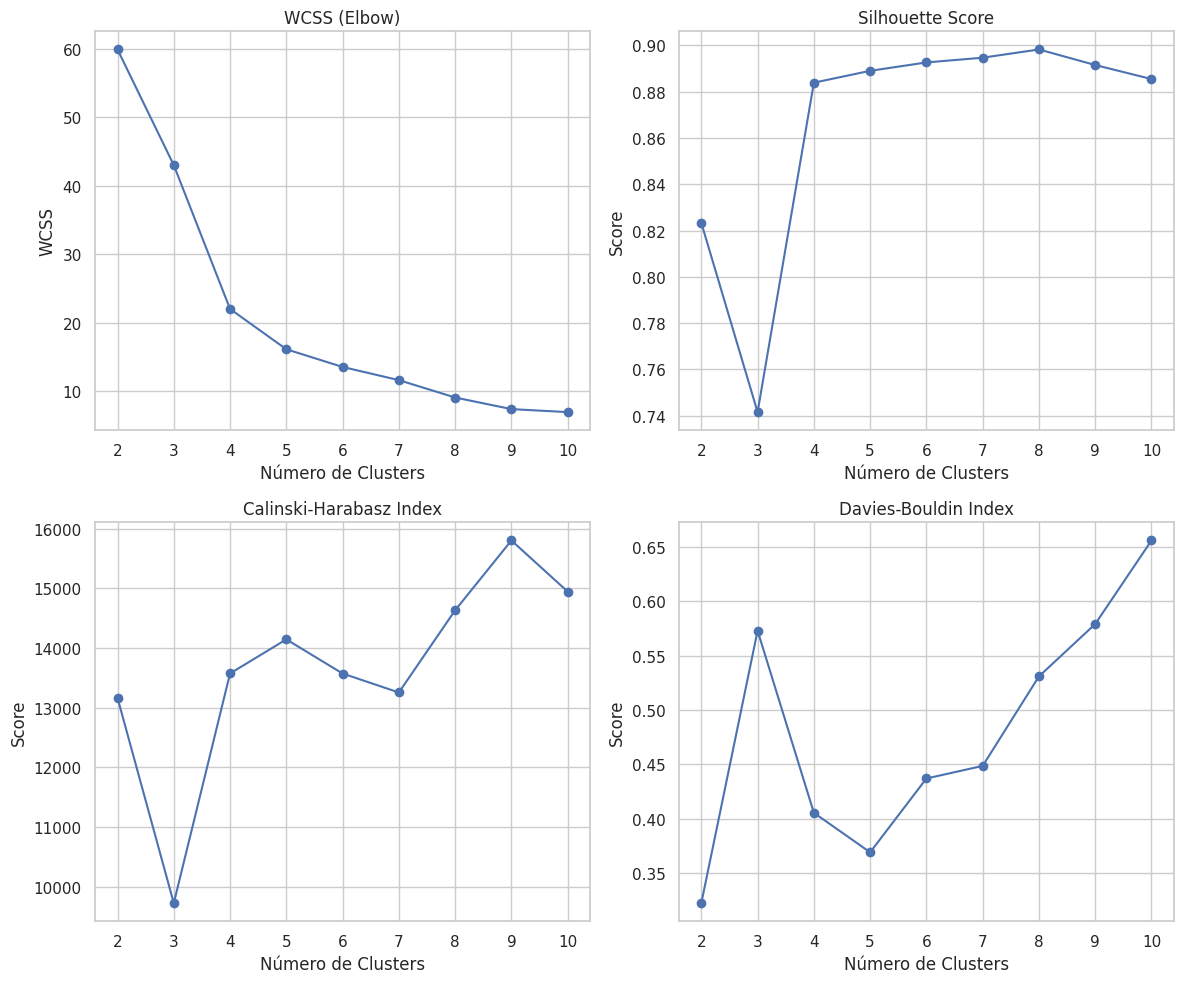

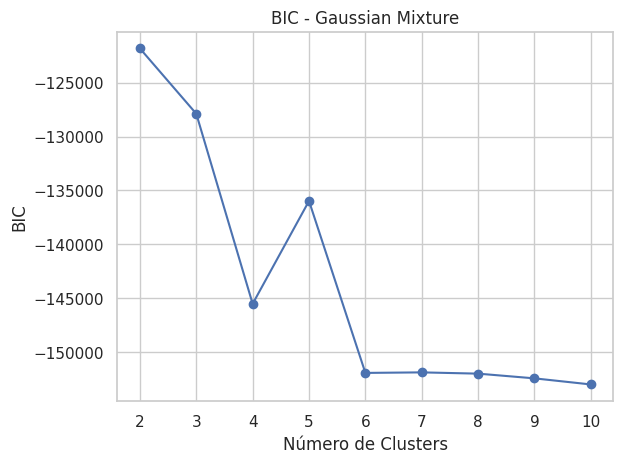

In [31]:
sns.set(style="whitegrid")
plt.figure(figsize=(12, 10))

# WCSS (cotovelo)
plt.subplot(2, 2, 1)
plt.plot(k_range, wcss, marker='o')
plt.title('WCSS (Elbow)')
plt.xlabel('Número de Clusters')
plt.ylabel('WCSS')

# Silhouette
plt.subplot(2, 2, 2)
plt.plot(k_range, silhouette, marker='o')
plt.title('Silhouette Score')
plt.xlabel('Número de Clusters')
plt.ylabel('Score')

# Calinski-Harabasz
plt.subplot(2, 2, 3)
plt.plot(k_range, calinski, marker='o')
plt.title('Calinski-Harabasz Index')
plt.xlabel('Número de Clusters')
plt.ylabel('Score')

# Davies-Bouldin (quanto menor, melhor)
plt.subplot(2, 2, 4)
plt.plot(k_range, davies, marker='o')
plt.title('Davies-Bouldin Index')
plt.xlabel('Número de Clusters')
plt.ylabel('Score')

plt.tight_layout()
plt.show()

# BIC separado (opcional)
plt.figure()
plt.plot(k_range, bic, marker='o')
plt.title('BIC - Gaussian Mixture')
plt.xlabel('Número de Clusters')
plt.ylabel('BIC')
plt.show()


In [32]:
# Redução de dimensionalidade
pca = PCA(n_components=2)
X_pca = pca.fit_transform(train_set)

In [33]:
feature_names =  train_set.columns.tolist()
importancia = pd.DataFrame(
    data=pca.components_,
    columns=feature_names,
    index=[f'PC{i+1}' for i in range(2)]
)

print("Contribuição das variáveis em cada Componente Principal:")
print(importancia.T)

# Variância explicada por componente
print("\nVariância explicada por cada componente:")
print(f"PC1: {pca.explained_variance_ratio_[0]:.2%}")
print(f"PC2: {pca.explained_variance_ratio_[1]:.2%}")

Contribuição das variáveis em cada Componente Principal:
                               PC1       PC2
postsAmount               0.023833  0.048468
postRepliesAmount         0.007500  0.072159
helpRequestsAmount        0.015193  0.597394
helpRequestRepliesAmount  0.011230  0.796979
performance_rate          0.999509 -0.019732

Variância explicada por cada componente:
PC1: 94.57%
PC2: 1.92%


In [34]:
# Treinamento do K-Means
kmeans = KMeans(n_clusters=4)
y_kmeans = kmeans.fit_predict(X_pca)

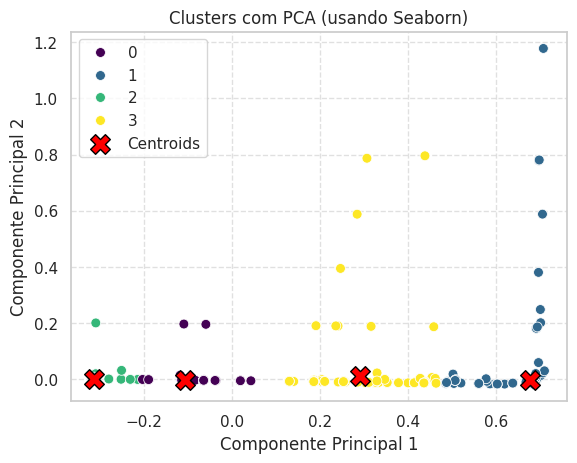

In [35]:
# 1. (Opcional mas recomendado) Coloque seus dados em um DataFrame do Pandas
df_pca = pd.DataFrame({
    'PCA1': X_pca[:, 0],
    'PCA2': X_pca[:, 1],
    'Cluster': y_kmeans
})

# 2. Use o scatterplot do Seaborn
# O parâmetro 'hue' diz ao Seaborn para colorir os pontos com base na coluna 'Cluster'
# e criar uma legenda automaticamente.
sns.scatterplot(data=df_pca, x='PCA1', y='PCA2', hue='Cluster', palette='viridis', s=50)

# 3. Plotar os centróides por cima (usando Matplotlib)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
            s=200, c='red', label='Centroids', marker='X', edgecolors='black')

# 4. Adicionar título e customizações
plt.title('Clusters com PCA (usando Seaborn)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [36]:
tabela_contagem = pd.Series(y_kmeans).value_counts()


# Exibe a tabela final
print("Quantidade de itens por cluster:")
print(tabela_contagem)

Quantidade de itens por cluster:
0    1572
2     650
1     466
3     197
Name: count, dtype: int64


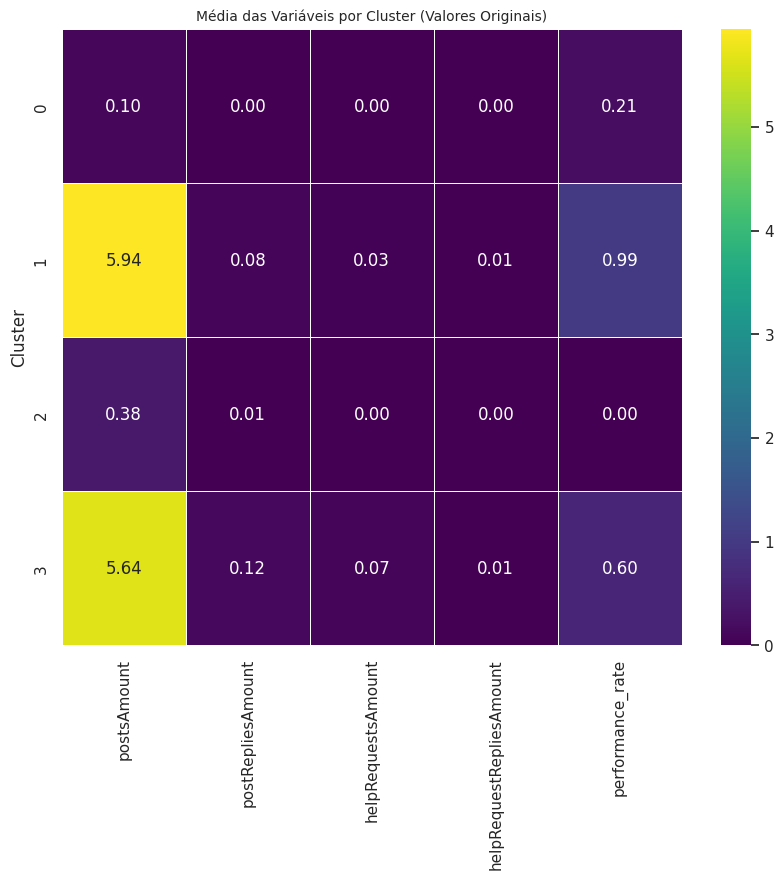

In [37]:
dados_revertidos_np = scaler.inverse_transform(train_set)
train_set_revertido = pd.DataFrame(dados_revertidos_np, columns=train_set.columns, index=train_set.index)

dados_originais_com_clusters = train_set_revertido.copy()
dados_originais_com_clusters['cluster'] = y_kmeans
cluster_means = dados_originais_com_clusters.groupby('cluster').mean()

#cluster_means_para_plotar = cluster_means

plt.figure(figsize=(10, 8))

sns.heatmap(
    cluster_means,
    annot=True,
    fmt='.2f',
    cmap='viridis',
    linewidths=.5
)

plt.title('Média das Variáveis por Cluster (Valores Originais)', fontsize=10)
plt.ylabel('Cluster', fontsize=12)
plt.show()

--- Regras da Árvore de Decisão ---
|--- performance_rate <= 0.11
|   |--- class: 2
|--- performance_rate >  0.11
|   |--- performance_rate <= 0.40
|   |   |--- class: 0
|   |--- performance_rate >  0.40
|   |   |--- performance_rate <= 0.79
|   |   |   |--- class: 3
|   |   |--- performance_rate >  0.79
|   |   |   |--- class: 1


--- Visualização da Árvore ---


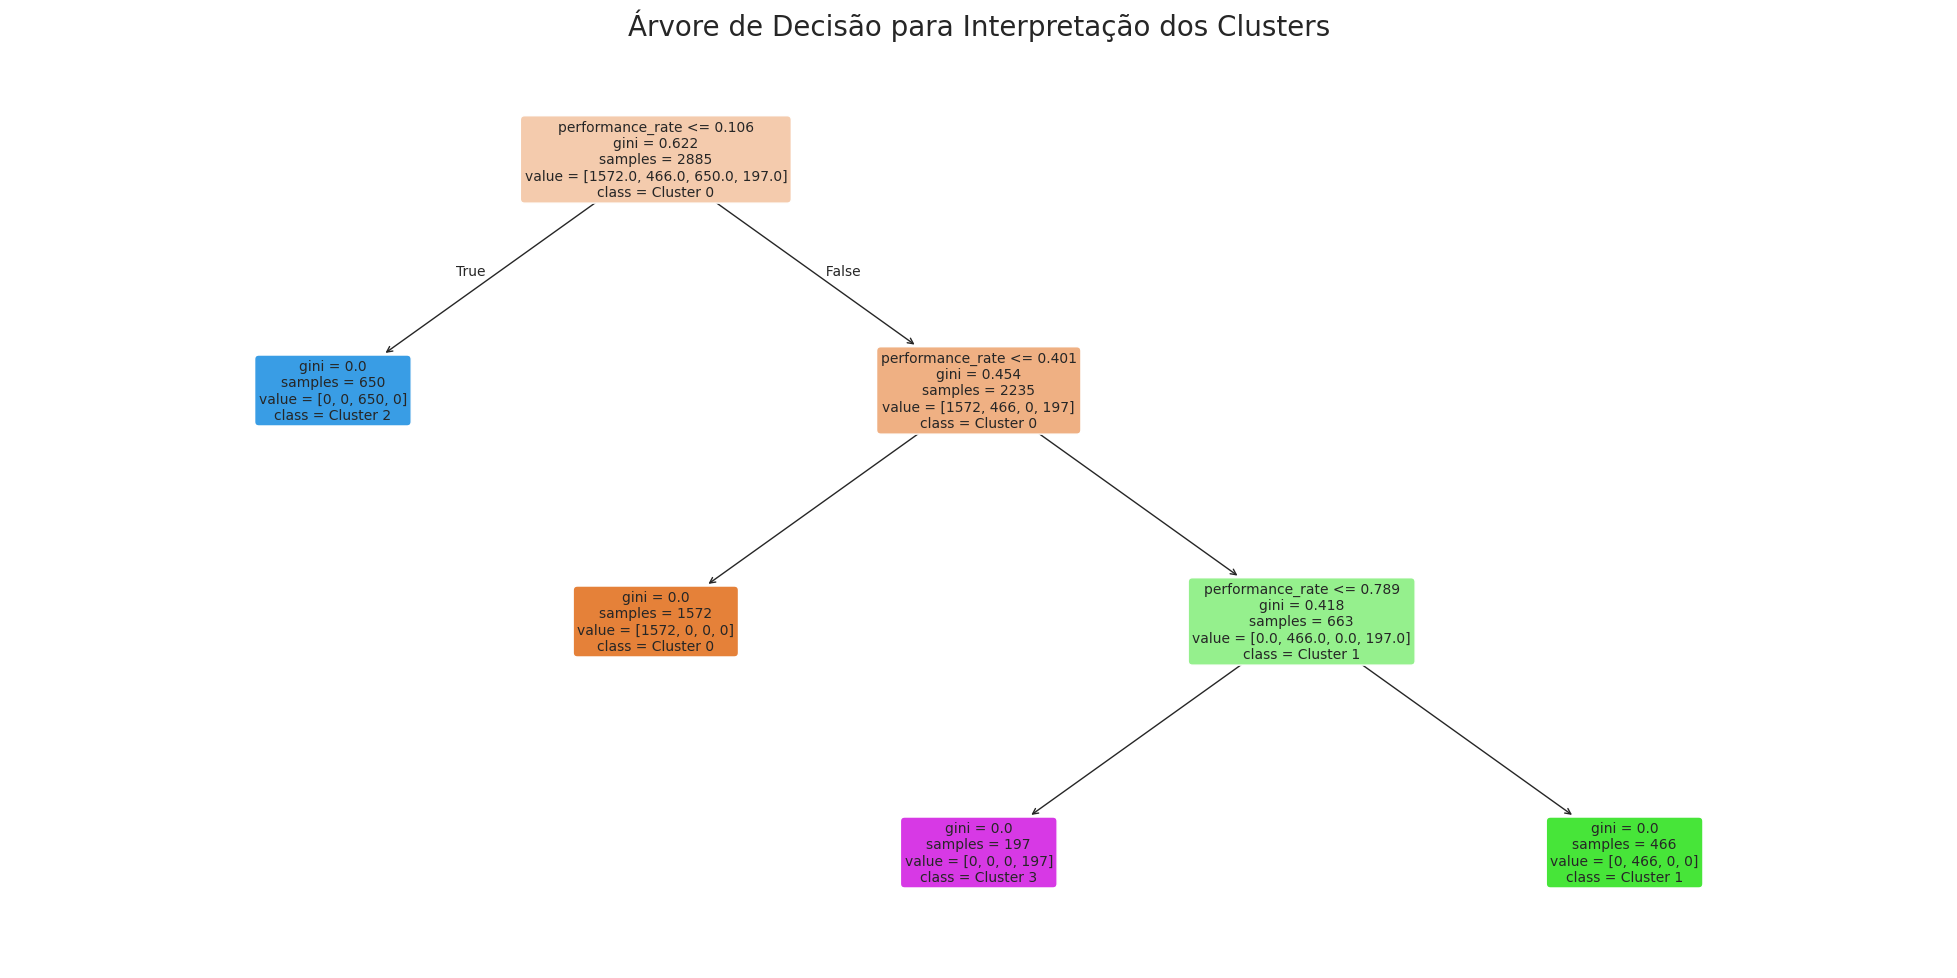

In [38]:
# --- 2. TREINAR A ÁRVORE DE DECISÃO ---

# Definir as features (X) e o alvo (y)
X = train_set
y = y_kmeans

# Inicializar o classificador.
# max_depth=3 significa que teremos no máximo 3 níveis de regras. É ótimo para interpretação.
# random_state garante que o resultado seja o mesmo toda vez.
arvore_de_decisao = DecisionTreeClassifier(max_depth=3, random_state=42)

# Treinar a árvore para aprender a mapear as features para os clusters
arvore_de_decisao.fit(X, y)


# --- 3. EXTRAIR E VISUALIZAR AS REGRAS ---

# Método 1: Extrair as regras como texto (muito útil!)
print("--- Regras da Árvore de Decisão ---")
nomes_features = X.columns.tolist()
regras_texto = export_text(arvore_de_decisao, feature_names=nomes_features)
print(regras_texto)


# Método 2: Visualizar a árvore de decisão (ainda mais intuitivo)
print("\n--- Visualização da Árvore ---")
# Nomes das classes para a legenda do gráfico
nomes_classes = [f'Cluster {i}' for i in sorted(np.unique(y))]

plt.figure(figsize=(25, 12))
plot_tree(
    arvore_de_decisao,
    feature_names=nomes_features,
    class_names=nomes_classes,
    filled=True,  # Colore os nós para indicar a classe majoritária
    rounded=True, # Deixa os nós com cantos arredondados
    fontsize=10
)
plt.title("Árvore de Decisão para Interpretação dos Clusters", fontsize=20)
plt.show()

In [39]:

train_set['cluster'] = y_kmeans

centroids_interpretacao_df = train_set.groupby('cluster').mean()

print("--- Médias das Variáveis Originais por Cluster ---")
print(centroids_interpretacao_df)
print("-" * 50)

mapa_de_labels = {}

id_consistente = centroids_interpretacao_df['postsAmount'].idxmax()
mapa_de_labels[id_consistente] = "Engajamento consistente"

# "Não interagem": Menor performance rate
id_nao_interagem = centroids_interpretacao_df['performance_rate'].idxmin()
mapa_de_labels[id_nao_interagem] = "não interagem"

# Identifica e classifica os dois clusters restantes
indices_restantes = [c for c in centroids_interpretacao_df.index if c not in mapa_de_labels]

if centroids_interpretacao_df.loc[indices_restantes[0], 'performance_rate'] > centroids_interpretacao_df.loc[indices_restantes[1], 'performance_rate']:
    mapa_de_labels[indices_restantes[0]] = "Engajamento excelente"
    mapa_de_labels[indices_restantes[1]] = "Desempenho crítico"
else:
    mapa_de_labels[indices_restantes[1]] = "Engajamento excelente"
    mapa_de_labels[indices_restantes[0]] = "Desempenho crítico"


print("\n--- Mapa de Labels Gerado Automaticamente ---")
print(mapa_de_labels)

# Passo 4: Aplicar o mapa gerado
train_set['categoria_interacao'] = train_set['cluster'].map(mapa_de_labels)

print("\n--- Contagem final das novas categorias ---")
print(train_set['categoria_interacao'].value_counts())

--- Médias das Variáveis Originais por Cluster ---
         postsAmount  postRepliesAmount  helpRequestsAmount  \
cluster                                                       
0           0.000342           0.000098            0.000424   
1           0.021146           0.006108            0.011445   
2           0.001336           0.001065            0.000513   
3           0.020088           0.009371            0.023689   

         helpRequestRepliesAmount  performance_rate  
cluster                                              
0                        0.000000          0.207725  
1                        0.008584          0.989706  
2                        0.000000          0.000650  
3                        0.010152          0.603579  
--------------------------------------------------

--- Mapa de Labels Gerado Automaticamente ---
{np.int32(1): 'Engajamento consistente', np.int32(2): 'não interagem', 3: 'Engajamento excelente', 0: 'Desempenho crítico'}

--- Contagem final das 

In [40]:
dataset_clss = train_set.copy()
dataset_clss.head()

,postsAmount,postRepliesAmount,helpRequestsAmount,helpRequestRepliesAmount,performance_rate,cluster,categoria_interacao
0,0.000000,0.0,0.0,0.0,0.000000,2,não interagem
1,0.035587,0.0,0.0,0.0,0.566667,3,Engajamento excelente
2,0.000000,0.0,0.0,1.0,0.609524,3,Engajamento excelente
3,0.000000,0.0,0.0,0.0,0.200000,0,Desempenho crítico
4,0.000000,0.0,0.0,0.0,0.000000,2,não interagem


In [41]:
dataset_clss.tail()

,postsAmount,postRepliesAmount,helpRequestsAmount,helpRequestRepliesAmount,performance_rate,cluster,categoria_interacao
2880,0.0,0.0,0.0,0.0,0.0,2,não interagem
2881,0.0,0.0,0.0,0.0,0.0,2,não interagem
2882,0.0,0.0,0.0,0.0,0.0,2,não interagem
2883,0.0,0.0,0.0,0.0,0.0,2,não interagem
2884,0.0,0.0,0.0,0.0,0.0,2,não interagem


In [42]:
dataset_clss.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2885 entries, 0 to 2884
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   postsAmount               2885 non-null   float64
 1   postRepliesAmount         2885 non-null   float64
 2   helpRequestsAmount        2885 non-null   float64
 3   helpRequestRepliesAmount  2885 non-null   float64
 4   performance_rate          2885 non-null   float64
 5   cluster                   2885 non-null   int32  
 6   categoria_interacao       2885 non-null   object 
dtypes: float64(5), int32(1), object(1)
memory usage: 146.6+ KB
